# Clustering

### Dataset: Marketing in Banking

Source: https://www.kaggle.com/janiobachmann/bank-marketing-dataset

(Original source: https://archive.ics.uci.edu/ml/datasets/bank+marketing)

#### Input variables:

##### bank client data:
 1. age (numeric)
 2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
 3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
 4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
 5. default: has credit in default? (categorical: 'no','yes','unknown')
 6. housing: has housing loan? (categorical: 'no','yes','unknown')
 7. loan: has personal loan? (categorical: 'no','yes','unknown')

##### related with the last contact of the current campaign:
 8. contact: contact communication type (categorical: 'cellular','telephone') 
 9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
 10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
 11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

##### other attributes:
 12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
 13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
 14. previous: number of contacts performed before this campaign and for this client (numeric)
 15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

##### social and economic context attributes
 16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
 17. cons.price.idx: consumer price index - monthly indicator (numeric) 
 18. cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
 19. euribor3m: euribor 3 month rate - daily indicator (numeric)
 20. nr.employed: number of employees - quarterly indicator (numeric)
 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

%matplotlib inline

## Load Data

In [2]:
df = pd.read_csv('bank.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
age          11162 non-null int64
job          11162 non-null object
marital      11162 non-null object
education    11162 non-null object
default      11162 non-null object
balance      11162 non-null int64
housing      11162 non-null object
loan         11162 non-null object
contact      11162 non-null object
day          11162 non-null int64
month        11162 non-null object
duration     11162 non-null int64
campaign     11162 non-null int64
pdays        11162 non-null int64
previous     11162 non-null int64
poutcome     11162 non-null object
deposit      11162 non-null object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [4]:
# Ignore the deposit column (which is actually the label for
# a different task - classification)

# Here, we want to discover clusters in the features
features = df.columns[df.columns != 'deposit']

## Data Cleaning

### Missing Values

In [5]:
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

No NaN values to clean!

### Categorical Features

There are quite a few categorical features to encode.

In [6]:
for f in features:
    if (df[f].dtypes == 'object'):
        print(f, df[f].unique())

job ['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']
marital ['married' 'single' 'divorced']
education ['secondary' 'tertiary' 'primary' 'unknown']
default ['no' 'yes']
housing ['yes' 'no']
loan ['no' 'yes']
contact ['unknown' 'cellular' 'telephone']
month ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
poutcome ['unknown' 'other' 'failure' 'success']


In [7]:
from sklearn.preprocessing import LabelEncoder

# store encoders in a dictionary so that we
# can refer to them easily for using / saving / loading
encoders = dict()

for f in features:
    if (df[f].dtypes == 'object'):
        encoder = LabelEncoder()
        encoder.fit(df[f])
        df[f] = encoder.transform(df[f])
        # or if you don't want to replace columns:
        # df[f + '_enc'] = encoder.transform(df[f])
        encoders[f] = encoder

In [8]:
# inspect the encoded classes
for k, v in encoders.items():
    print(k, v.classes_)

job ['admin.' 'blue-collar' 'entrepreneur' 'housemaid' 'management' 'retired'
 'self-employed' 'services' 'student' 'technician' 'unemployed' 'unknown']
marital ['divorced' 'married' 'single']
education ['primary' 'secondary' 'tertiary' 'unknown']
default ['no' 'yes']
housing ['no' 'yes']
loan ['no' 'yes']
contact ['cellular' 'telephone' 'unknown']
month ['apr' 'aug' 'dec' 'feb' 'jan' 'jul' 'jun' 'mar' 'may' 'nov' 'oct' 'sep']
poutcome ['failure' 'other' 'success' 'unknown']


## Data Visualisation

C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\kml\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\kml\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


[Text(0, 0.5, 'Z[1]'), Text(0.5, 0, 'Z[0]'), Text(0.5, 1.0, '2-d PCA plot')]

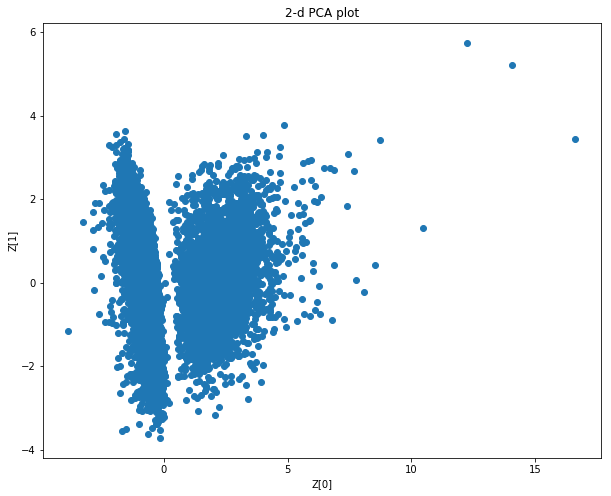

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

pca_2d = PCA(n_components=2)
Z_2d = pca_2d.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(Z_2d[:, 0], Z_2d[:, 1])
ax.set(xlabel='Z[0]', ylabel='Z[1]', title='2-d PCA plot')

## KMeans Clustering

- Run K-means with 2 or 3 clusters
- Examine Elbow plot to find any better K
- Explore relationships between clusters and features

### KMeans (clusters = 2)

In [10]:
km = KMeans(n_clusters=2)
clusters = km.fit_predict(X_scaled)

In [11]:
clusters

array([1, 1, 1, ..., 1, 0, 1])

In [12]:
from sklearn.metrics import silhouette_score

# metric (b-a)/max(a, b)
# b = inter cluster distance (should be large for good clustering)
# a = intra cluster distance (should be small for compact clustering)
silhouette_score(X_scaled, clusters)

0.1750772754976835

In [13]:
# sum of squared distance from closest centroid
km.inertia_

156253.33039246342

### Elbow Plot

In [14]:
inertias = {}
for n in range(2, 10):
    km_temp = KMeans(n_clusters=n)
    km_temp.fit(X_scaled)
    inertias[n] = km_temp.inertia_

Text(0, 0.5, 'inertia')

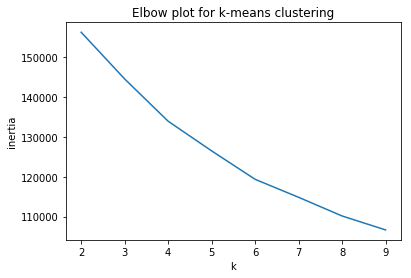

In [15]:
fig, ax = plt.subplots()
ax.plot(inertias.keys(), inertias.values())
ax.set_title('Elbow plot for k-means clustering')
ax.set_xlabel('k')
ax.set_ylabel('inertia')

In [16]:
# The graph shows no clear "elbow". Clustering of 2 is probably as good as you get from looking at the PCA plot.

### Exploring clusters

[Text(0, 0.5, 'Z[1]'),
 Text(0.5, 0, 'Z[0]'),
 Text(0.5, 1.0, '2-d PCA plot with clusters')]

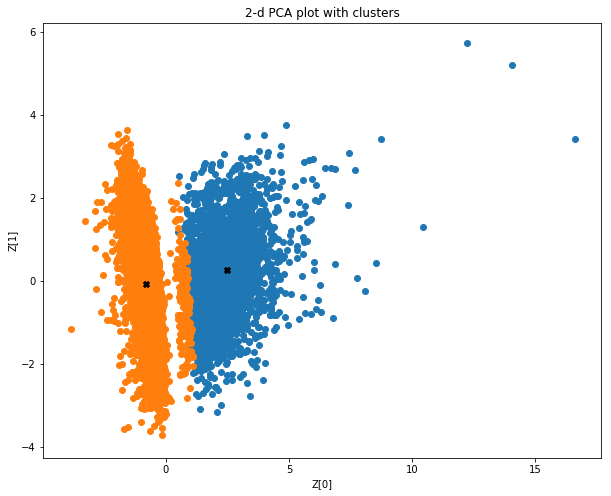

In [17]:
# plot cluster centroids and cluster assignments
fig, ax = plt.subplots(figsize=(10, 8))

# How to read this:
#
#                   first PCA dimension
#                   |
# Z_2d[clusters==0, 0]
#     |
#     filtered to indices where clusters == 0
#
ax.scatter(Z_2d[clusters==0, 0], Z_2d[clusters==0, 1], label='cluster 0')
ax.scatter(Z_2d[clusters==1, 0], Z_2d[clusters==1, 1], label='cluster 1')

# Plot the cluster centroids
# These also need to be reduced to 2 dimensions before
# we can plot them
cluster_centers_2d = pca_2d.transform(km.cluster_centers_)
ax.scatter(cluster_centers_2d[:, 0], cluster_centers_2d[:, 1], label='centroids', marker='X', color='black')

ax.set(xlabel='Z[0]', ylabel='Z[1]', title='2-d PCA plot with clusters')